# **Task 2: Predictive Modelling**

1. Using the `transactions_edited` dataset, identify the annual salary for each customer.

2. Explore correlations between annual salary and various other customer attributes such as `age`, `gender`, et al. These attributes could be those that are readily available in the data (such as age) or those that need to be derived (such as purchase behaviour). Visualize any interesting correlations using a scatter plot.

3. Build a simple Linear Regression model to predict the annual salary for each customer using the attributes you have identified.

4. How accurate is your model? Should ANZ use it to segment customers (who don't have access to this data) into income brackets for reporting purposes?

5. For a challenge, build a Decision-Tree based model to predict salary. Does it perform better than the Linear Regression model? How would you accurately test the performance of this Decision-Tree model?

## **Python Implementation**

In [80]:
# Load relevant libraries
import pandas as pd
import statistics as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')

In [5]:
# Load the relevant dataset
url = 'https://raw.githubusercontent.com/srssrobin/ANZ-Data-Analytics-Virtual-Internship/refs/heads/main/transactions_edited.csv'
df = pd.read_csv(url)


df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

## **Feature Engineering**

In order to model annual salary, we first need to compute the annual salary for each customer as well as create features that can help predict those salaries. In other words, we have to come up with a way to compute the annual salary for each customer, which, is going to be our target variable.

The way we are going to go about doing this is by:
1. Looping through all `Salary` type transactions for each customer
2. Asume that the `Salary Level` is constant for each customer during the observed period

In [6]:
# Initialize empty lists to hold frequency and amount values
df_freq = []
df_amount = []

# Collect all the Customer IDs
salary_df = pd.DataFrame({"customer_id": df["customer_id"].unique()})
print(salary_df)

       customer_id
0   CUS-2487424745
1   CUS-2142601169
2   CUS-1614226872
3   CUS-2688605418
4   CUS-4123612273
..             ...
95  CUS-2505971401
96  CUS-2819545904
97  CUS-3395687666
98  CUS-1147642491
99   CUS-261674136

[100 rows x 1 columns]


In [10]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = df.loc[(df.customer_id == salary_df.customer_id[customer]) &
     (df.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(sc.mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount
salary_df["annual_salary"] = round(salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25, 0)
salary_df.head()


,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52892.0
1,CUS-2142601169,7,1002.13,52290.0
2,CUS-1614226872,7,892.09,46548.0
3,CUS-2688605418,14,2320.30,60535.0
4,CUS-4123612273,7,1068.04,55729.0


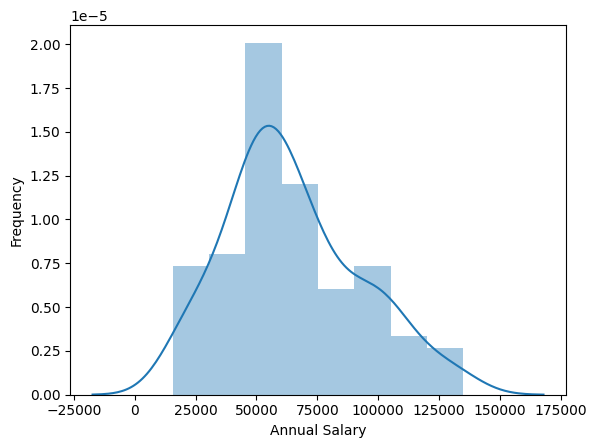

In [11]:
# Distribution of the annual salary
sns.distplot(salary_df.annual_salary)
plt.xlabel("Annual Salary")
plt.ylabel("Frequency")
plt.show()

## **Understanding the Salary Analysis Code**

This code processes salary payment data for each customer and estimates their salary frequency, salary amount, and annual salary based on the available transactions. Let’s walk through the code step-by-step to understand what it does.

### **1. Looping Through Each Customer**
The code starts by looping through every customer in the `salary_df` DataFrame, which presumably holds customer IDs and other related salary data.

```python
for customer in range(len(salary_df)):
```
- `salary_df` is assumed to contain information like customer IDs.
- For each customer, the code looks at all their salary-related transactions.

### **2. Filtering Salary Payments**
Next, it filters the transactions for each customer where the transaction description is "PAY/SALARY" (i.e., salary payments).

```python
salary = df.loc[(df.customer_id == salary_df.customer_id[customer]) &
    (df.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
```
- `df` contains the entire transaction dataset.
- It selects only the rows where the `customer_id` matches the current customer and where the transaction description is `"PAY/SALARY"`.
- It then groups these salary transactions by the date and sums up the `amount` for each day (if there are multiple transactions on the same day, their amounts are added together).

### **3. Handling Customers with No Salary Payments**
If the customer has no salary payments recorded (i.e., there are no matching salary records), the code appends `NaN` (Not a Number) for both salary amount and frequency.

```python
count = len(salary)
if count == 0:
    df_amount.append(np.nan)
    df_freq.append(np.nan)
```
- If there are no salary payments, it stores `NaN` for both the `salary_amount` and `salary_freq` for that customer.

### **4. Calculating Salary Payment Frequency**
For customers who have salary payments, the code calculates the number of days between each payment (i.e., how often the customer receives a salary).

```python
else:
    days_between_payments = []
    for date in range(len(salary)-1):
        days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
```
- `days_between_payments` is a list that stores the number of days between each consecutive salary payment.
- For example, if a customer received payments on the 1st, 5th, and 10th of the month, the days between payments would be 4 and 5, respectively.
- The code calculates this for all the salary payments of the customer.

### **5. Storing the Maximum Frequency**
After calculating the number of days between each salary payment, it stores the maximum value in `df_freq`, which represents the longest gap between two payments.

```python
df_freq.append(max(days_between_payments))
```
- This means the customer’s salary payment frequency is based on the longest gap between payments.

### **6. Calculating the Most Frequent Salary Amount**
The code then calculates the most frequent salary amount for the customer using the `mode()` function, which returns the most common value in the salary amounts.

```python
df_amount.append(mode(salary.amount)[0])
```
- `mode(salary.amount)` finds the most frequent salary amount.
- `mode(salary.amount)[0]` is used to extract the first mode value, in case there are multiple modes.

### **7. Calculating the Estimated Annual Salary**
The code then calculates an estimate of the customer’s annual salary using the formula:

```python
salary_df["annual_salary"] = round(salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25, 0)
```
- It divides the `salary_amount` (most frequent salary) by the `salary_freq` (maximum days between salary payments) and multiplies it by 365.25 (to account for leap years).
- This gives an estimate of the customer’s annual salary, which is then rounded to the nearest whole number.

### **8. Final DataFrame**
At the end of the process, you get a DataFrame (`salary_df`) with three new columns:
- **`salary_freq`**: The frequency (in days) of salary payments for each customer.
- **`salary_amount`**: The most frequent salary amount paid to the customer.
- **`annual_salary`**: The estimated annual salary based on the most frequent salary and payment frequency.

### **Conclusion**
This code provides a way to calculate salary frequency, most frequent salary amount, and estimate the annual salary for each customer. It assumes that the salary stays constant over the observed period for each customer, and it uses the mode to find the most common salary value. It’s useful for analyzing salary data and understanding how often customers receive payments.


## **Creating Predictor Variables/Features**

Predictor variables will help us predict salaries for each customer. We will create the following features:

1. Avarage number of weekly transactions
2. Maximum transaction amount
3. Number of large transactions (> AU$ 100)
4. Number of days with transactions
5. Average transaction amount
6. Median Balance
7. State of residence
8. Age
9. Gender

## **Here’s how we will go about calculating the average weekly transactions for each customer step by step:**

We are trying to calculate the average number of weekly transactions, for each customer. The logic used to calculate the average number of weekly transactions for a single customer is as follows:

1. **Filter transactions for the customer:**  Extract the transaction dates for a specific customer.

2. **Count the total number of transactions:** Determine how many transactions this customer made in total.

3. **Count the number of unique dates:** Identify the unique dates on which the customer made transactions.

4. **Calculate the Average Daily Transactions:** Divide the total number of transactions by the number of unique dates.

5. **Extrapolate this to weekly transactions:** Multiply the daily average by 7 to estimate the average weekly transaction amount.

``` python
# Assuming 'df' is the main DataFrame and 'customer_id' is the column of customer IDs

# Filter transaction dates for a single customer
customer_id = 'C123'  # Example customer ID
customer_data = df.loc[df['customer_id'] == customer_id, 'date']

# Calculate total number of transactions
total_transactions = len(customer_data)

# Calculate number of unique transaction days
unique_days = customer_data.nunique()

# Handle edge case: If no unique days, set average to 0
if unique_days == 0:
    avg_weekly_transactions = 0
else:
    # Calculate daily average and scale to weekly
    avg_daily_transactions = total_transactions / unique_days
    avg_weekly_transactions = avg_daily_transactions * 7

print(f"Customer {customer_id}: {avg_weekly_transactions} weekly transactions (on average).")
```

We extraplolate this logic to all customers in a dataframe using a For-Loop:
1. **Identify the unique customers:**
  - Extract the unique customer IDs from the `customer_id` column.

2. **Loop through each customer:**
  - For each customer, filter their transaction data
  - Perform calculations using the logic described as above for a single customer.

3. **Store results:**
  - Save the calculated weekly averages for each customer in a list or another structure.

``` python
# Step 1: Get unique customer IDs
unique_customers = df['customer_id'].unique()

# Step 2: Initialize a list to store the averages
avg_weekly_transactions = []

# Step 3: Loop through each customer
for customer_id in unique_customers:
    # Filter transaction dates for this customer
    customer_data = df.loc[df['customer_id'] == customer_id, 'date']
    
    # Calculate total transactions and unique days
    total_transactions = len(customer_data)
    unique_days = customer_data.nunique()
    
    # Handle edge case: No unique days
    if unique_days == 0:
        avg_weekly = 0
    else:
        # Calculate average weekly transactions
        avg_daily_transactions = total_transactions / unique_days
        avg_weekly = avg_daily_transactions * 7
    
    # Append the result to the list
    avg_weekly_transactions.append(avg_weekly)

# Optional: Display the first few results
print(avg_weekly_transactions[:5])

```
### **1. Initialize Unique Customer IDs**
   ```python
   unique_id = df['customer_id'].unique()
   ```
   - This line extracts all unique customer IDs from the `customer_id` column of the `df` DataFrame.
   - The `unique()` function ensures no duplicates are included, creating a list of unique customers.

---

### **2. Prepare a List for Results**
   ```python
   avg_weekly_transactions = []
   ```
   - This initializes an empty list to store the calculated average weekly transactions for each customer.

---

### **3. Iterate Through Each Customer**
   ```python
   for id_ in unique_id:
   ```
   - Loops through each unique customer ID to calculate their respective average weekly transactions.

---

### **4. Filter Dates for Each Customer**
   ```python
   array = df.loc[df.customer_id == id_, "date"]
   ```
   - Filters the rows in `df` where the `customer_id` matches the current `id_`.
   - Extracts only the `date` column for this filtered subset. This results in a series of dates when the customer made transactions.

---

### **5. Calculate Average Weekly Transactions**
   ```python
   avg = len(array) / array.nunique() * 7
   ```
   - **`len(array)`**: Counts the total number of transactions made by the customer.
   - **`array.nunique()`**: Counts the number of unique days on which the transactions occurred.
   - Divides the total number of transactions by the number of unique days to get the average daily transactions.
   - Multiplies the result by `7` to convert the daily average into a weekly average.

---

### **6. Store the Result**
   ```python
   avg_weekly_transactions.append(avg)
   ```
   - Appends the calculated average weekly transactions for the current customer to the `avg_weekly_transactions` list.

---

### **7. Display First 5 Results**
   ```python
   avg_weekly_transactions[:5]
   ```
   - Displays the first five calculated average weekly transaction values for inspection.

---

### **Key Insights:**
- The code calculates the average number of weekly transactions for each customer based on the frequency of their transactions and the number of unique transaction days.
- This approach accounts for irregular transaction days and normalizes the frequency over a week.

---

### Suggested Improvements:
1. **Optimize with Pandas Groupby**:
   - The current loop-based method can be slow for large datasets. Using `groupby` in Pandas can achieve the same result more efficiently.
   ```python
   df['date'] = pd.to_datetime(df['date'])
   grouped = df.groupby('customer_id')['date'].agg(['count', 'nunique'])
   grouped['avg_weekly_transactions'] = grouped['count'] / grouped['nunique'] * 7
   avg_weekly_transactions = grouped['avg_weekly_transactions'].tolist()
   ```

2. **Handle Edge Cases**:
   - Ensure `array.nunique()` is not `0` to avoid division errors.


In [12]:
# 1. Average number of weekly transactions per customer
unique_id = df['customer_id'].unique()
avg_weekly_transactions = []

for id_ in unique_id:
    array = df.loc[df.customer_id == id_, "date"]
    avg = len(array)/array.nunique()*7
    avg_weekly_transactions.append(avg)

avg_weekly_transactions[:5]

[47.6,
 28.66216216216216,
 23.855263157894736,
 14.333333333333332,
 21.318181818181817]

In [17]:
# 2.Maximum amount for each customer; we'll use the same logic as above
  # 1. Collect all the unique customer_ids
  # 2. Initialize an empty list called max_amount that will hold the max amount for each customer
  # 3. df.loc[df.customer_id == 'CUS-2487424745', "amount"].max()
  # 4. Use a for loop to iterate for over each customer and append the max amount to max_amount list

unique_id = df['customer_id'].unique()
max_amount = []

for id_ in unique_id:
    max_amount.append(df.loc[df.customer_id == id_, "amount"].max())

max_amount[:5]



[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

It's a little tricky for calculating the total number of transactions greater than AU$100, for each customer. We will use a counter as follows

```python
count = 0

for amount in df.loc[df['customer_id'] == 'CUS-2487424745', 'amount']:
  if amount > 100:
    count = count+1

print(count)
```

In [28]:
# 3. Do the same for number of large transactions (i.e. transactions > AU$100)
# Initialize an empty list called large_transactions
# For each customer:
  # initialize a counter
  # run a for loop to iterate over each of their transaction amount
  # increment counter for each transaction greater than 100
  # get out of the for loop
  # append the count to the large_transactions list

large_transactions = []
unique_id = df['customer_id'].unique()

for id_ in unique_id:
  count = 0
  for amount in df.loc[df['customer_id'] == id_, 'amount']:
    if amount > 100:
      count = count + 1

  large_transactions.append(count)

large_transactions[:5]


[22, 23, 22, 25, 32]

Average transaction amount for a single customer

```python
print(df.loc[df['customer_id'] == 'CUS-2487424745', 'amount'].mean())
```

In [29]:
# 4. Average transaction amount for each customer; use a for loop and append:
avg_transactions = []
unique_id = df['customer_id'].unique()

for id_ in unique_id:
  array = df.loc[df.customer_id == id_, "amount"]
  avg = array.mean()
  avg_transactions.append(avg)

avg_transactions[:5]



[45.34877162629758,
 78.20610561056105,
 74.46501930501931,
 159.30418604651166,
 166.5083582089552]

In [30]:
# 5. Median balance for each customer
median_balance = []
unique_id = df['customer_id'].unique()

for id_ in unique_id:
  array = df.loc[df['customer_id'] == id_, 'amount']
  median = array.median()
  median_balance.append(median)

median_balance[:5]

[11.28, 15.97, 25.38, 24.0, 29.46]

In [43]:
# 6. State of residence
state = []

for id_ in unique_id:
  array = df.loc[df['customer_id'] == id_, 'merchant_state']
  state.append(sc.mode(array))

state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [45]:
# 7. Age
age = []

for id_ in unique_id:
  array = df.loc[df['customer_id'] == id_, 'age']
  age.append(sc.mode(array))

age[:5]

[26, 38, 40, 20, 43]

In [46]:
# 8. Gender
gender = []

for id_ in unique_id:
  array = df.loc[df['customer_id'] == id_, 'gender']
  gender.append(sc.mode(array))

gender[:5]

['F', 'M', 'F', 'M', 'F']

In [48]:
# Put everything together into one dataframe and call it "Inputs"
inputs = pd.DataFrame({"Customer_ID": unique_id,
                       "Avg_Weekly_Trans": avg_weekly_transactions,
                       "Max_Amount": max_amount,
                       "Num_Large_Trans": large_transactions,
                       "Avg_Trans_Amoutn": avg_transactions,
                       "Median_Balance": median_balance,
                       "State": state,
                       "Age": age,
                       "Gender": gender})

## **Pre-Processing**

In [65]:
y = salary_df['annual_salary']
X = inputs.drop('Customer_ID', axis = 1)

In [66]:
# Transform the categorical columns into numerical columns
le = LabelEncoder()
X['State'] = le.fit_transform(X['State'])
X['Gender'] = le.fit_transform(X['Gender'])

In [67]:
# Standardize numerical variables
scaler = StandardScaler()

X['Avg_Weekly_Trans'] = scaler.fit_transform(X[['Avg_Weekly_Trans']])
X['Max_Amount'] = scaler.fit_transform(X[['Max_Amount']])
X['Num_Large_Trans'] = scaler.fit_transform(X[['Num_Large_Trans']])
X['Avg_Trans_Amount'] = scaler.fit_transform(X[['Avg_Trans_Amoutn']])
X['Median_Balance'] = scaler.fit_transform(X[['Median_Balance']])


In [61]:
X.head(10)

,Avg_Weekly_Trans,Max_Amount,Num_Large_Trans,Avg_Trans_Amoutn,Median_Balance,State,Age,Gender,Avg_Trans_Amount
0,5.149635,-0.661927,0.359722,-1.487057,-1.489918,2,26,0,-1.487057
1,2.042529,-0.030698,0.515057,-1.152479,-1.122923,0,38,1,-1.152479
2,1.253867,-1.055940,0.359722,-1.190574,-0.386585,2,40,0,-1.190574
3,-0.308383,-0.051274,0.825727,-0.326680,-0.494571,0,20,1,-0.326680
4,0.837611,-0.932169,1.913069,-0.253322,-0.067323,3,43,0,-0.253322
5,1.811384,0.314412,0.515057,-0.934940,-0.821658,4,27,0,-0.934940
8,-0.322775,1.062736,1.291731,1.080635,0.304758,0,23,1,1.080635
10,1.333936,-0.411212,-0.106282,-1.157817,-1.000069,2,30,1,-1.157817
14,0.937616,-0.805514,0.825727,-1.057374,-0.881520,3,24,0,-1.057374
15,1.152284,1.196658,0.670392,-1.033665,-1.192566,2,37,1,-1.033665


In [69]:
# Do test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## **Fit a Linear Regression**


In [71]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 0)
print("RMSE: ", rmse)

RMSE:  21370.0


## **Fit a Decision Tree Model**

We can fit a Decision Tree both on Numerical and Categorical target variable. Here, we'll look at fitting a DT classification model by first partitioning the salary variable into 3 groups:

1. Low = less than AU$ 45,000

2. Medium = less than AU$ 81,000

3. High = greater than AU$ 81,000

In [84]:
salary_class = []

for salary in y:
  if salary < 45000:
    salary_class.append("Low")
  elif salary < 81000:
    salary_class.append("Medium")
  elif salary >= 81000:
    salary_class.append("High")

# Convert it into a dataframe
salary_class = pd.DataFrame(salary_class, columns = ["Salary_Class"])

In [85]:
# Encode salary class using LabelEncoder
le = LabelEncoder()
salary_class['Salary_Class_Encoded'] = le.fit_transform(salary_class['Salary_Class'])
salary_class.head()

,Salary_Class,Salary_Class_Encoded
0,Medium,2
1,Medium,2
2,Medium,2
3,Medium,2
4,Medium,2


In [86]:
salary_class.value_counts()

,,count
Salary_Class,Salary_Class_Encoded,
Medium,2,52
High,0,26
Low,1,22


In [79]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, salary_class['Salary_Class_Encoded'], test_size = 0.2, random_state = 42)

In [81]:
# Fit a decision tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)


RMSE:  1.0


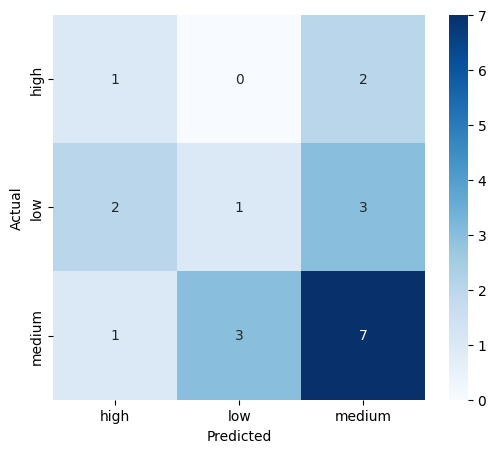

In [97]:
# Create a confusion matrix and heatmap to evaluate the results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test, y_pred)
f1 = round(f1_score(y_test, y_pred, average='weighted'),2)

# Map the encoded values to their corresponding salary classes
labels = ['high', 'low', 'medium']

# Plot the heatmap with custom labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labeling the axes
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()



In [98]:
print("F1 Score:", f1)

F1 Score: 0.44


## **Summary**


An **F1 score of 0.44** suggests that my model's performance is moderate, and there’s room for improvement, particularly in balancing **precision** and **recall**. The F1 score combines both precision and recall into a single value, giving me an idea of how well the model is performing overall—especially in cases where the dataset is imbalanced.

To break it down:
- A **low F1 score** typically means that either my **precision** (how many of the predicted positives are correct) or **recall** (how many of the actual positives were captured) is low.
- The **F1 score** is sensitive to class imbalances. If one class dominates the dataset, it can significantly affect the overall F1 score.

Here are some steps I can take to improve it:

### 1. **Check Class Imbalance:**
If my data is highly imbalanced (i.e., one class appears much more frequently than the others), the model may be biased toward the majority class. In this case, metrics like **precision**, **recall**, and **F1 score** for the minority class are more useful.

### 2. **Adjust the Model:**
I could tweak the model by:
- **Changing the algorithm**: Trying other classification models (e.g., Random Forest, SVM, etc.).
- **Hyperparameter tuning**: Using grid search or random search to find better settings for the model.
- **Class weight adjustment**: Some models allow me to assign more importance to the minority class, like using `class_weight='balanced'` in algorithms like Logistic Regression or Random Forest.

### 3. **Use Cross-Validation:**
I should make sure to use **cross-validation** to avoid overfitting and better assess the model's generalizability.

### 4. **Feature Engineering:**
Improving my features can make a significant difference in the F1 score. I could:
- Add new features
- Remove irrelevant or noisy features
- Scale or transform the features

### 5. **Evaluate by Class:**
It’s important to look at precision, recall, and F1 score for each class individually. To do this, I can use `classification_report()`:

```python
from sklearn.metrics import classification_report

# Print classification report for detailed performance metrics per class
print(classification_report(y_test, y_pred))
```

This will give me the precision, recall, and F1 score for each class, helping me understand where my model is struggling.
